# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Цель проекта — Построить модель для прогнозирования количества заказов такси на следующий час с метрикой RMSE на тестовой выборке не больше 48.

## Установка и импорт библиотек, определение констант

In [1]:
# Манипуляции с данными и анализ
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix

# Компоненты Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler
)
from sklearn.tree import DecisionTreeRegressor

# Статистическое моделирование
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose

# Другие библиотеки машинного обучения
from catboost import CatBoostRegressor

In [2]:
# Собственные функции
from utils import (
    phik_correlation_matrix,
    vif,
    analyze_residuals    
)

In [3]:
# константа RANDOM_STATE
RANDOM_STATE = 42

# константа TEST_SIZE
TEST_SIZE = 0.10

## Загрузка данных

In [4]:
try:
    # Пробуем основной путь
    df_init = pd.read_csv(
        '/datasets/taxi.csv',
        index_col=[0],
        parse_dates=[0]
    )

except FileNotFoundError:
    print("⚠️ Файл не найден в /datasets/, пробуем из текущей директории...")
    try:
        df_init = pd.read_csv(
            'taxi.csv',
            index_col=[0],
            parse_dates=[0]
        )
    except FileNotFoundError:
        print("❌ Ошибка: Файл 'taxi.csv' не найден ни в /datasets/, ни в текущей директории.")

except Exception as e:
    print(f"❌ Критическая ошибка при загрузке данных: {str(e)}")

⚠️ Файл не найден в /datasets/, пробуем из текущей директории...


In [5]:
# Информация о загруженных данных
print("\n✅ Данные загружены:")
print(f"- Набор данных: {df_init.shape[0]} строк, {df_init.shape[1]} столбцов")
print("- Первые строки:")
df_init.head(3)


✅ Данные загружены:
- Набор данных: 26496 строк, 1 столбцов
- Первые строки:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


**Промежуточный вывод**

Все данные из описания присутствуют, загрузка прошла успешно. Данные готовы к предобработке.

## Предобработка данных

In [6]:
# сделаем копию датафрейма
taxi_df = df_init.copy()

Проверим данные на наличие пропусков, а также в хронологическом ли порядке расположены даты и время. Узнаем, корректный ли тип данных у числового признака `num_orders`.

In [7]:
# выведем общую информацию
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропуски отсутствуют, тип данных `num_orders` соответствует описанию.

In [8]:
# в Яндекс Практикуме
#taxi_df.index.is_monotonic
# при работе локально
taxi_df.index.is_monotonic_increasing

True

Дата и время расположены в хронологическом порядке.

Согласно первичному осмотру данных разница по времени между записями 10 минут. Выполним ресемплирование данных по одному часу с суммой в качестве агрегирующей функции.

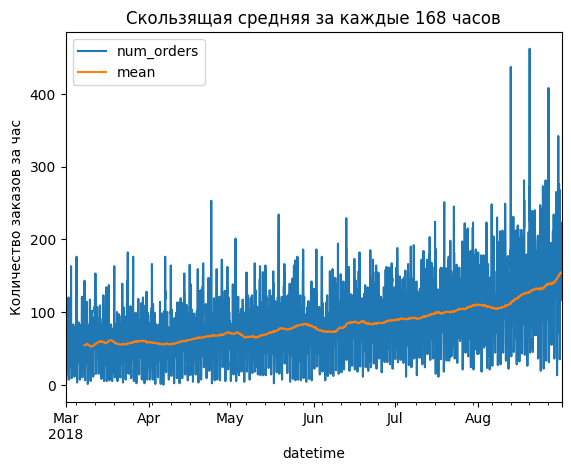

In [9]:
# в Яндекс Практикуме
#data = taxi_df.resample('1H').sum()
# при работе локально
data = taxi_df.resample('1h').sum()
# продемонстрируем скользяющую среднюю за каждые 168 часов
data['mean'] = data.rolling(168).mean()

data.plot(
    ylabel='Количество заказов за час',
    title='Скользящая средняя за каждые 168 часов'
);

График указывает, что от месяца к месяцу медианное значение количества заказов растет. Проанализируем тренды и сезонность.


**Промежуточные выводы по предобработке**

- Пропуски отсутствуют, тип данных `num_orders` соответствует описанию.
- Дата и время расположены в хронологическом порядке.
- Общий тренд на рост количества заказов с увеличением темпов роста от месяца к месяцу.

## Исследовательский анализ данных

Проведем исследовательский анализ с целью определение важных признаков.

Объект DecomposeResult создадим с декомпозицией с недельной сезонностью, так как именно неделя всегда имеет определенное количество дней. При этом отдельно можно будет исследовать еще и суточную сезонность.

In [10]:
# Создадим объект DecomposeResult
decomposed = seasonal_decompose(
    data['num_orders'] # извлекаем ряд
    .interpolate(method='time') # заполняем пропуски с учётом времени
    .asfreq('1h'), # гарантируем почасовую частоту
    model='additive', # аддитивная модель декомпозиции
    period=168 # декомпозиция с недельной сезонностью
)

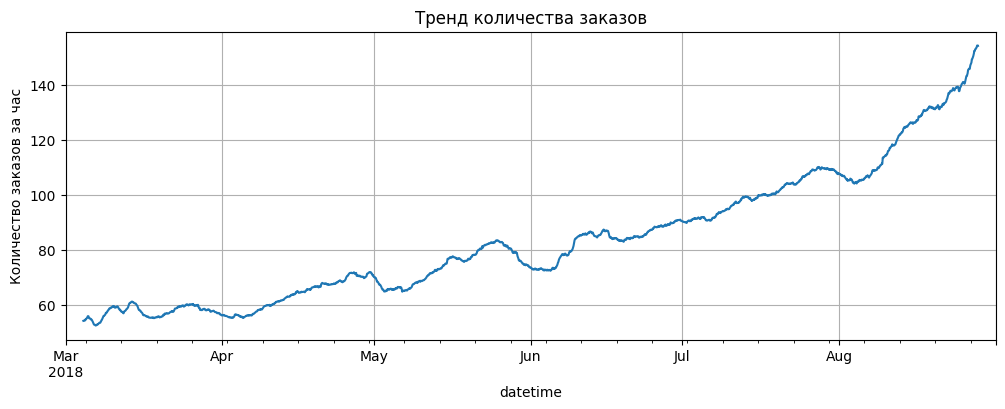

In [11]:
decomposed.trend.plot(title='Тренд количества заказов', figsize=(12, 4))
plt.ylabel('Количество заказов за час')
plt.grid(True)
plt.show()

Тренд полностью повторяет скользяющую среднюю за каждые 168 часов: от месяца к месяцу на промежутке от марта по август медианное значение количества заказов растет.

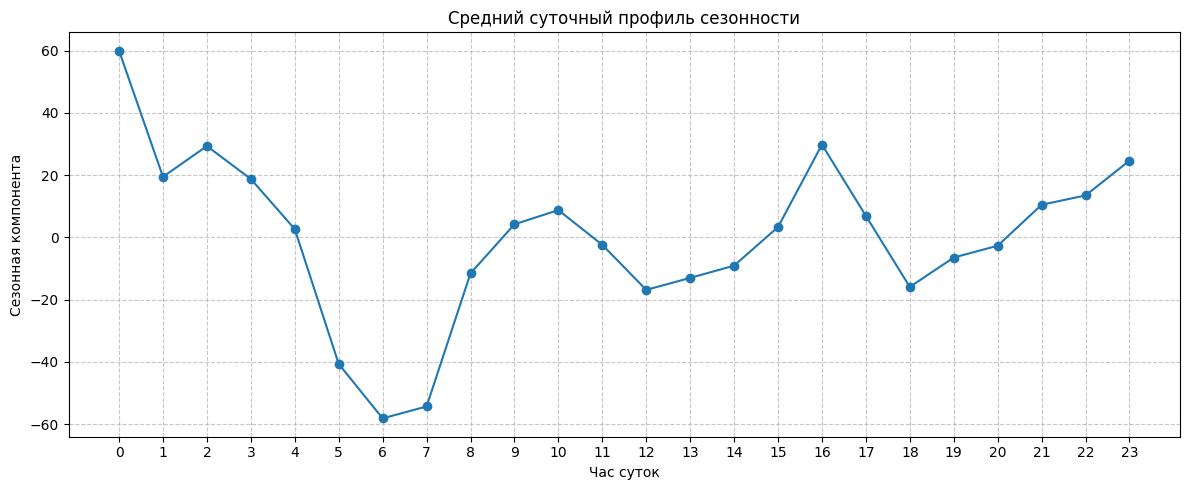

In [12]:
# Средний суточный профиль
hourly_profile = decomposed.seasonal.groupby(decomposed.seasonal.index.hour).mean()

# Построение графика
ax = hourly_profile.plot(
    title='Средний суточный профиль сезонности',
    figsize=(12, 5),
    marker='o'
)

# Устанавливаем тик для КАЖДОГО часа (0–23)
ax.set_xticks(range(24))

# Поворачиваем подписи, чтобы не налезали
plt.xticks(rotation=0)

plt.xlabel('Час суток')
plt.ylabel('Сезонная компонента')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Мы наблюдаем, что ориентировочно с 6 утра начинается рост количества заказов, который в среднем продолжается до полуночи, после чего количество заказов идет на спад вплоть до 6 утра. При этом можно выделить локальные максимумы активности внутри дня. Так мы наблюдаем локальный максимум в 10 часов, в 16 часов. Данные максимумы могут быть объяснены популярными рейсами, которые прибывают в это время. Максимальное значение количества заказов приходится на полночь, что может быть связано с нерабочим временем общественного транспорта и высокой потребностью в далеких поездках. Дальнейший спад в ночное время возможно связан с уменьшением количества людей в аэропортах.

----------------------------------------

**Исследование недельной сезонности**

In [13]:
data_d = taxi_df.resample('1d').sum()

In [14]:
# Создадим объект DecomposeResult
decomposed_d = seasonal_decompose(
    data_d['num_orders'] # извлекаем ряд
    .interpolate(method='time') # заполняем пропуски с учётом времени
    .asfreq('1d'), # гарантируем частоту в 1 день
    model='additive', # аддитивная модель декомпозиции
    period=7 # декомпозиция с недельной сезонностью
)

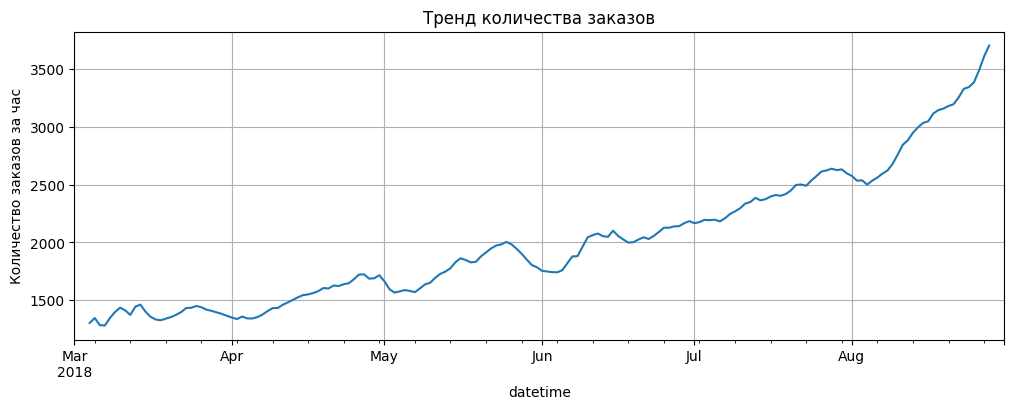

In [15]:
decomposed_d.trend.plot(title='Тренд количества заказов', figsize=(12, 4))
plt.ylabel('Количество заказов за час')
plt.grid(True)
plt.show()

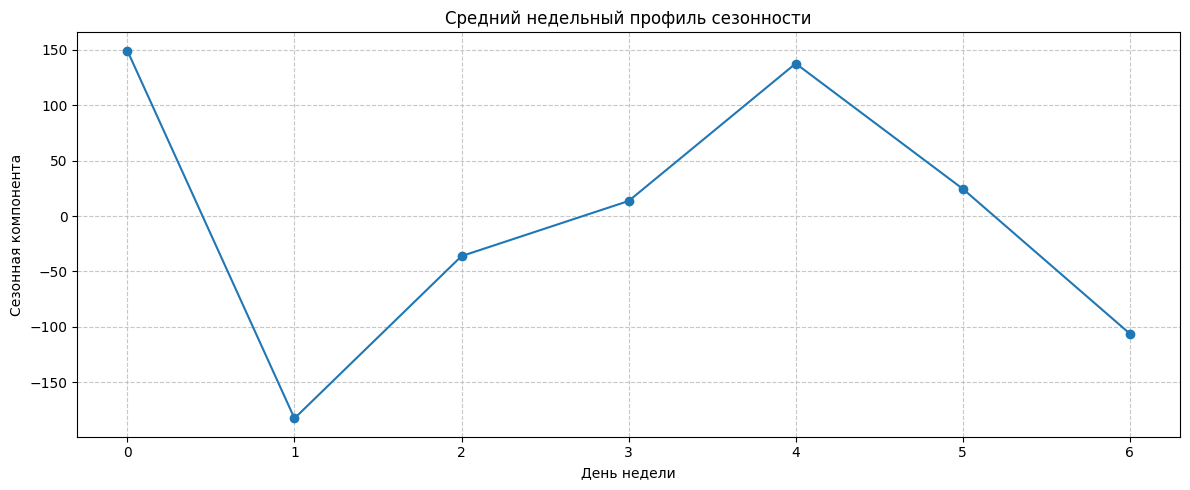

In [16]:
# Средний недельный профиль
hourly_profile = decomposed_d.seasonal.groupby(decomposed_d.seasonal.index.dayofweek).mean()

# Построение графика
ax = hourly_profile.plot(
    title='Средний недельный профиль сезонности',
    figsize=(12, 5),
    marker='o'
)

# Устанавливаем тик для КАЖДОГО часа (0–23)
ax.set_xticks(range(7))

# Поворачиваем подписи, чтобы не налезали
plt.xticks(rotation=0)

plt.xlabel('День недели')
plt.ylabel('Сезонная компонента')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Наблюдается недельная сезонность: минимум заказов во вторник и воскресенье, а максимум в понедельник и пятницу.

----------------------------------------

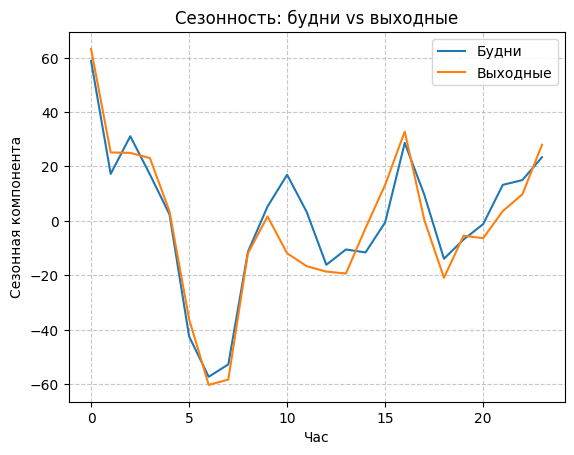

In [17]:
# сравним будни с выходными
seasonal = decomposed.seasonal
seasonal_weekdays = seasonal[seasonal.index.dayofweek < 5]  # пн-пт
seasonal_weekends = seasonal[seasonal.index.dayofweek >= 5] # сб-вс

seasonal_weekdays.groupby(seasonal_weekdays.index.hour).mean().plot(label='Будни')
seasonal_weekends.groupby(seasonal_weekends.index.hour).mean().plot(label='Выходные')
plt.legend()
plt.title('Сезонность: будни vs выходные')
plt.xlabel('Час')
plt.ylabel('Сезонная компонента')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Единственное отличие выходных от будней — пик на 10 часов сместился на меньшее значение и стал значительно слабее. Данный факт может быть связан с уменьшением популярности рейсов в данное время или отсутствием данных рейсов в выходные в принципе.

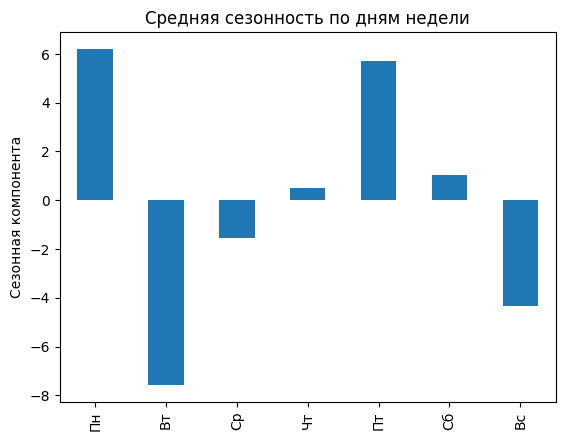

In [18]:
# средняя сезонность по дням недели
weekly_profile = decomposed.seasonal.groupby(decomposed.seasonal.index.dayofweek).mean()
weekly_profile.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
weekly_profile.plot(kind='bar', title='Средняя сезонность по дням недели')
plt.ylabel('Сезонная компонента')
plt.show()

Наиболее популярно такси в понедельник и пятницу, а вот менее популярно во вторник и воскресенье. 

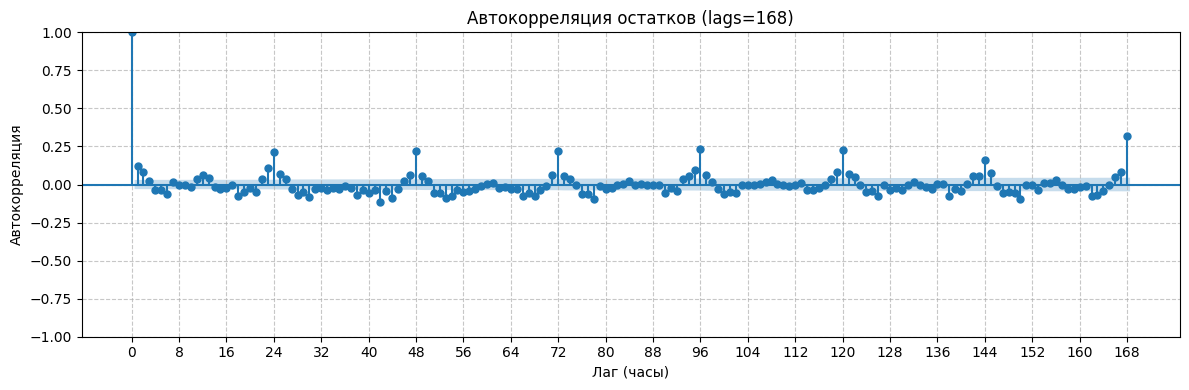

In [19]:
# Строим ACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(decomposed.resid.dropna(), lags=168, ax=ax)

# Устанавливаем тик для КАЖДОГО 8 лага
ax.set_xticks(range(0, 169, 8))

# Поворачиваем подписи, если нужно
plt.xticks(rotation=0)

plt.title('Автокорреляция остатков (lags=168)')
plt.xlabel('Лаг (часы)')
plt.ylabel('Автокорреляция')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Анализ остатков созданного объекта DecomposeResult с недельной сезонностью демонстрирует суточную сезонность, которая отдельно ранее была исследована.

**Промежуточные выводы**

1. Медианное значение количества заказов растет с марта по август 2018 года 
2. С 6:00 утра начинается рост числа заказов, который сохраняется до полуночи. С полуночи до 6:00 утра наблюдается спад активности — минимальный спрос на такси.
3. В течение дня выделяются локальные пик в 10:00 и 16:00 — возможно, популярные рейсы дня.
4. Абсолютный максимум приходится на 00:00, что может объясняться:
    - прекращением работы общественного транспорта;
    - ростом спроса на дальние или ночные поездки.
5. Ночное снижение заказов после полуночи обусловлено общим падением мобильности населения.
6. Пик в 10 часов на выходных слабее по сравнению с этим же пиком в будни, что, вероятно, связано с отсутствием популярности рейсов, прибывающих в данное время, или их отсутствием в выходные в принципе.
7. Наиболее популярно такси в понедельник и пятницу, а вот менее популярно во вторник и воскресенье.
8. Наблюдается как суточная, так и недельная сезонности. 

На основе проведенного исследовательского анализа можно сформировать следующие важные признаки для модели прогнозирования почасового спроса на такси в аэропортах:

1. **Время суток**  
   - Час дня (0–23) — основной признак для учёта суточной сезонности.  
   - Бинарные индикаторы для ключевых интервалов:  
     - `is_early_morning` (06:00–09:00),  
     - `is_daytime` (10:00–17:00),  
     - `is_evening_night` (18:00–23:00),  
     - `is_deep_night` (00:00–05:00).

2. **День недели**  
   - Категориальный признак `day_of_week` (0 — понедельник, ..., 6 — воскресенье).  
   - Учёт пониженной активности во вторник и воскресенье, повышенной — в понедельник и пятницу.

3. **Тип дня**  
   - `is_weekday` / `is_weekend` — для моделирования различий в утреннем пике (особенно в 10:00).

4. **Тренд (долгосрочная динамика)**  
   - Порядковый номер часа от начала периода (`hour_since_start`) — для захвата общего роста спроса с марта по август.
  
5. **Лаг**
    - Числовой признак, который несет информацию о прошлом.
    
6. **Скользящая средняя**
    - Характеризует тренд.

## Создание признаков

In [20]:
# 1. Подготовка исходного временного ряда (целевой признак)
ts = data['num_orders'].interpolate(method='time').asfreq('1h')

# 2. Создаём DataFrame с целевым признаком
df = ts.to_frame(name='num_orders')

# 3. Извлекаем базовые временные признаки (временно, для расчётов)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 0=Пн, ..., 6=Вс

# 4. Бинарные индикаторы для интервалов времени суток (используем hour, один интервал не добавляем)
df['is_early_morning'] = ((df['hour'] >= 6) & (df['hour'] <= 9)).astype(int)
df['is_daytime'] = ((df['hour'] >= 10) & (df['hour'] <= 17)).astype(int)
df['is_evening_night'] = ((df['hour'] >= 18) & (df['hour'] <= 23)).astype(int)
# is_deep_night - не используем, чтобы избежать полной зависимости¶
#df['is_deep_night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype(int)

# 5. Тренд: порядковый номер часа от начала периода
#df['hour_since_start'] = np.arange(len(df))

# 6. Циклическое кодирование
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# 7. Удаляем исходные нециклические признаки hour и day_of_week
df = df.drop(columns=['hour', 'day_of_week'])

# 8. Добавляем лаги и скользяющую среднюю
# Лаги
for lag in range(1, 169):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

# Скользящее среднее (обратите внимание на параметр min_periods)
df['rolling_mean'] = df['num_orders'].shift().rolling(window=168, min_periods=1).mean()

# 9. Фильтрация по периоду (март–август 2018)
df = df[(df.index >= '2018-03-01') & (df.index <= '2018-08-31')]

# 10. Удаляем строки с пропусками в целевом признаке и новых признаках
df = df.dropna(subset=['num_orders'] + [f'lag_{i}' for i in range(1,4)] + ['rolling_mean'])

# Проверка
display(df.head())
print("\nФорма датасета:", df.shape)
print("Столбцы:", df.columns.tolist())

C:\Users\shaht\AppData\Local\Temp\ipykernel_9004\2096773227.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
C:\Users\shaht\AppData\Local\Temp\ipykernel_9004\2096773227.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
C:\Users\shaht\AppData\Local\Temp\ipykernel_9004\2096773227.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

,num_orders,is_early_morning,is_daytime,is_evening_night,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,lag_1,lag_2,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 03:00:00,66,0,0,0,0.707107,7.071068e-01,0.433884,-0.900969,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,0,0,0,0.866025,5.000000e-01,0.433884,-0.900969,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.500000
2018-03-01 05:00:00,6,0,0,0,0.965926,2.588190e-01,0.433884,-0.900969,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.800000
2018-03-01 06:00:00,12,1,0,0,1.000000,6.123234e-17,0.433884,-0.900969,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.833333
2018-03-01 07:00:00,15,1,0,0,0.965926,-2.588190e-01,0.433884,-0.900969,12.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.142857



Форма датасета: (4390, 177)
Столбцы: ['num_orders', 'is_early_morning', 'is_daytime', 'is_evening_night', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'lag_51', 'lag_52', 'lag_53', 'lag_54', 'lag_55', 'lag_56', 'lag_57', 'lag_58', 'lag_59', 'lag_60', 'lag_61', 'lag_62', 'lag_63', 'lag_64', 'lag_65', 'lag_66', 'lag_67', 'lag_68', 'lag_69', 'lag_70', 'lag_71', 'lag_72', 'lag_73', 'lag_74', 'lag_75', 'lag_76', 'lag_77', 'lag_78', 'lag_79', 'lag_80', 'lag_81', 'lag_82', 'lag_83', 'lag_84', 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4390 entries, 2018-03-01 03:00:00 to 2018-08-31 00:00:00
Freq: h
Columns: 177 entries, num_orders to rolling_mean
dtypes: float64(173), int32(3), int64(1)
memory usage: 5.9 MB


In [22]:
df.describe()

,num_orders,is_early_morning,is_daytime,is_evening_night,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,lag_1,lag_2,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
count,4390.000000,4390.000000,4390.000000,4390.000000,4390.000000,4.390000e+03,4390.000000,4390.000000,4390.000000,4390.000000,...,4233.000000,4232.000000,4231.000000,4230.000000,4229.000000,4228.000000,4227.000000,4226.000000,4225.000000,4390.000000
mean,84.006606,0.166743,0.333485,0.250114,-0.000173,-4.173010e-04,0.001977,-0.004515,83.959909,83.923235,...,81.390031,81.386815,81.397069,81.400236,81.414992,81.412252,81.407145,81.389967,81.368047,82.115646
std,44.598313,0.372788,0.471512,0.433128,0.707297,7.070772e-01,0.706079,0.708277,44.504464,44.437189,...,41.613787,41.618178,41.617750,41.622160,41.616016,41.620557,41.624156,41.614094,41.594614,22.907368
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.666667
25%,54.000000,0.000000,0.000000,0.000000,-0.707107,-7.071068e-01,-0.781831,-0.900969,54.000000,54.000000,...,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,61.697917
50%,78.000000,0.000000,0.000000,0.000000,0.000000,-1.836970e-16,0.000000,-0.222521,78.000000,78.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.425595
75%,107.000000,0.000000,1.000000,0.750000,0.707107,7.071068e-01,0.781831,0.623490,107.000000,107.000000,...,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,98.104167
max,462.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.974928,1.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,150.357143


**Промежуточный вывод:** Необходимые признаки с удовлетворяющим описанием созданы 

## Корреляционный анализ

<Figure size 1400x600 with 0 Axes>

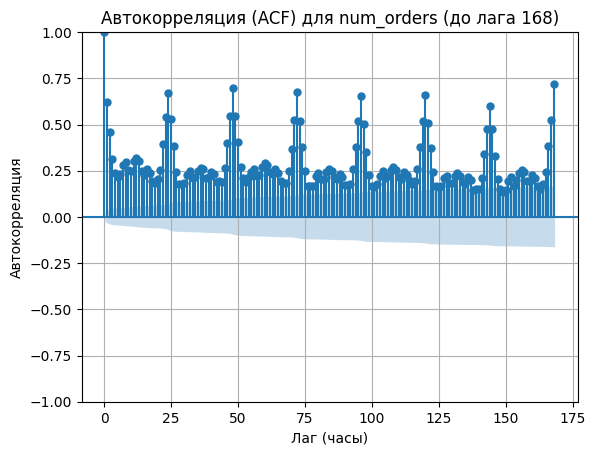

In [23]:
ts_clean = data['num_orders'].interpolate(method='time').asfreq('1h')
ts_clean = ts_clean[(ts_clean.index >= '2018-03-01') & (ts_clean.index <= '2018-08-31')]

# Построим ACF до лага 168
plt.figure(figsize=(14, 6))
plot_acf(ts_clean, lags=168, alpha=0.05)  # alpha — уровень значимости (95% доверительный интервал)
plt.title('Автокорреляция (ACF) для num_orders (до лага 168)')
plt.xlabel('Лаг (часы)')
plt.ylabel('Автокорреляция')
plt.grid(True)
plt.show()

Как и ожидалось, есть суточная (пики на X картном 24ч) и недельная сезонности (отличный от них пик на 168ч). В целях разумной экономии вычислительных ресурсов оставим лаги, соответствующие этим пикам. 

In [24]:
# 1. Формируем список нужных лагов
desired_lags = ['lag_1'] + [f'lag_{24 * i}' for i in range(1, 8)]  # 24*1=24, ..., 24*7=168

# Проверим, что получилось:
print("Оставляем лаги:", desired_lags)

# 2. Находим все столбцы-лаги в df
all_lag_columns = [col for col in df.columns if col.startswith('lag_')]

# 3. Находим лаги, которые НЕ входят в desired_lags → их удалим
lags_to_drop = [col for col in all_lag_columns if col not in desired_lags]

# 4. Удаляем ненужные лаги
df_filtered = df.drop(columns=lags_to_drop)
df_filtered = df_filtered.dropna()

# Проверка
print("\nОставшиеся лаги в датасете:")
print([col for col in df_filtered.columns if col.startswith('lag_')])
print("\nНовая форма:", df_filtered.shape)

Оставляем лаги: ['lag_1', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168']

Оставшиеся лаги в датасете:
['lag_1', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168']

Новая форма: (4225, 17)


## Обучение моделей

Разделяем данные на тренировочную и тестовую выборки

In [25]:
train, test = train_test_split(df_filtered, shuffle=False, test_size=TEST_SIZE)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Определяем тип признаков

In [26]:
df_filtered.columns

Index(['num_orders', 'is_early_morning', 'is_daytime', 'is_evening_night',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'lag_1',
       'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168',
       'rolling_mean'],
      dtype='object')

In [27]:
numerical_features = [
    #'hour_sin',
    #'hour_cos',
    #'day_of_week_sin',
    #'day_of_week_cos',
    'lag_1',
    'lag_24',
    'lag_48',
    'lag_72',
    'lag_96',
    'lag_120',
    'lag_144',
    'lag_168',
    'rolling_mean'
]
binary_features = ['is_early_morning', 'is_daytime', 'is_evening_night']

Функция для оценки моделей

In [28]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Так как GridSearchCV или RandomizedSearchCV максимизирует метрику, а RMSE нужно минимизировать,
# делаем его отрицательным:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [29]:
def evaluate_model(search, X_test, y_test, model_name):
    """Функция для оценки качества модели и времени обучения"""
    
    # Предсказания лучшей моделью
    y_pred = search.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Среднее время обучения одной модели (без подбора гиперпараметров и предсказаний)
    mean_fit_time = np.mean(search.cv_results_['mean_fit_time'])
    
    print(f"=== {model_name} ===")
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"Среднее время обучения одной модели: {mean_fit_time:.2f} сек")
    print("-" * 40)
    
    return {
        'MAE': mae, 
        'MSE': mse, 
        'RMSE': rmse, 
        'R2': r2, 
        'Time': mean_fit_time
    }

Настройка стратегии валидации моделей для временных рядов

In [30]:
# Создание схемы валидации
tscv = TimeSeriesSplit(n_splits=3)

Создание предобработчика для моделей `LinearRegressor` и `DecisionTreeRegressor`

In [31]:
# Пайплайн для обработки числовых признаков
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Главный предобработчик данных
preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numerical_features),
    ('bin', 'passthrough', binary_features)
], remainder='drop')

### LinearRegressor

In [32]:
# Финальный пайплайн
pipe_final_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [33]:
# введем гиперпараметры
param_grid = [
    # словарь для модели LinearRegression()
    {
        'preprocessor__num': ['passthrough']  
    }
]

In [34]:
# настроим GridSearchCV для кросс-валидации
grid_search = GridSearchCV(
    pipe_final_lr, 
    param_grid, 
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=2,
    error_score='raise'  # Вызывает исключение при ошибках
)

In [35]:
%%time
# обучаем модель на тренировочных данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 109 ms
Wall time: 1.61 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['lag_1',
                                                                          'lag_24',
                                                                          'lag_48',
                                                                          'lag_72',
                                                                          'lag_96',
                                                                          'lag_120',
                                                                          'lag_144',
                                                                          'lag_168',
                                                                          'rolling_mean']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['is_early_morning',
                                                                          'is_daytime',
                                                                          'is_evening_night'])])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid=[{'preprocessor__num': ['passthrough']}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=2)

In [36]:
# извлекаем pipline с лучшей моделью
best_model_lr = grid_search.best_estimator_
print('Лучшая модель и ее параметры:\n\n', best_model_lr)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['lag_1', 'lag_24', 'lag_48',
                                                   'lag_72', 'lag_96',
                                                   'lag_120', 'lag_144',
                                                   'lag_168', 'rolling_mean']),
                                                 ('bin', 'passthrough',
                                                  ['is_early_morning',
                                                   'is_daytime',
                                                   'is_evening_night'])])),
                ('regressor', LinearRegression())])


In [37]:
best_rmse_lr = -grid_search.best_score_

print(
    f'\033[1mМетрика RMSE лучшей модели best_model_lr '
    f'на кросс-валидационной выборке: '
    f'{best_rmse_lr:.4f}\n\033[0m'
)

Метрика RMSE лучшей модели best_model_lr на кросс-валидационной выборке: 23.0562



RMSE на тесте меньше 48, однако даже при этом коэффициент детерминации достаточно мал, что значит модель слабо объясняет дисперсию целевой переменной. При этом RMSE на кросс-валидации меньше, чем на тесте, что говорит о переобучении.

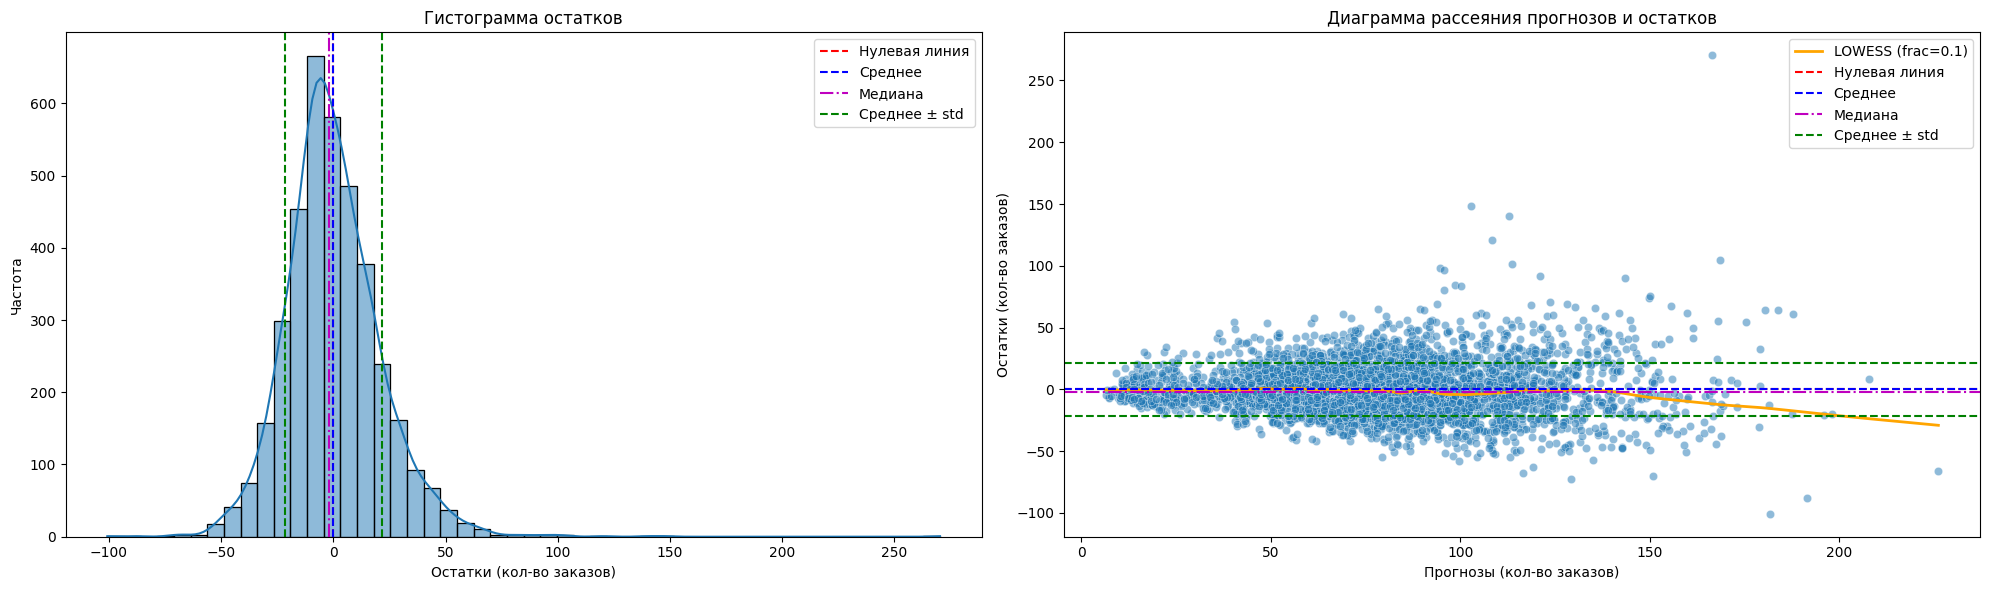

CPU times: total: 1.92 s
Wall time: 2.2 s


In [38]:
%%time
analyze_residuals(
    y_train,
    grid_search.predict(X_train),
    bins=50,
    figsize=(20, 6),
    title=None,
    lowess=True,
    lowess_frac=0.1,
    units='кол-во заказов'
)

Гистограмма остатков демонстрирует распределение, близкое к нормальному с центром в 0, что указывает на отсутствие систематической ошибки. Однако наличие выбросов в правом хвосте распределения (положительные остатки) свидетельствует о случаях, когда модель недооценивает фактические значения. Гомоскедастичность нарушена: дисперсия остатков увеличивается с ростом количества заказов.

Важность признаков

In [39]:
def get_feature_names_after_preprocessing(column_transformer):
    """Получает имена признаков после препроцессинга"""
    feature_names = []
    
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop':
            continue
            
        if hasattr(transformer, 'get_feature_names'):
            # Для трансформеров с get_feature_names (OneHotEncoder и т.д.)
            if callable(getattr(transformer, 'get_feature_names')):
                feature_names.extend(transformer.get_feature_names(columns))
        else:
            # Для трансформеров без get_feature_names (StandardScaler и т.д.)
            feature_names.extend(columns)
    
    return feature_names

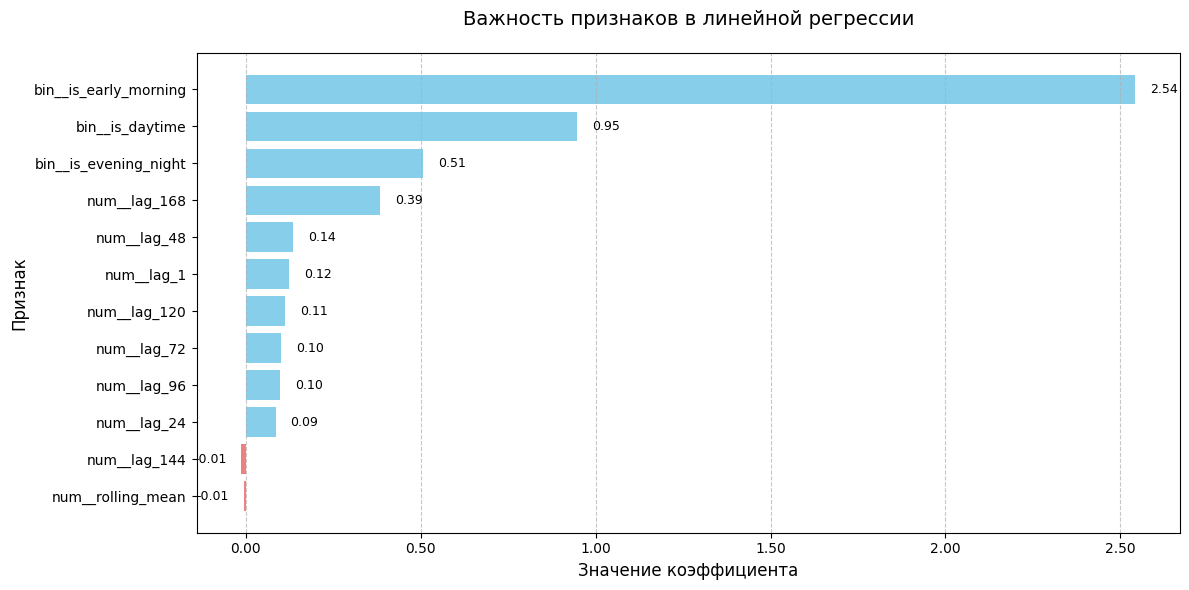

In [40]:
# Извлекаем препроцессор и регрессор из пайплайна
preprocessor = best_model_lr.named_steps['preprocessor']
regressor = best_model_lr.named_steps['regressor']

# Получаем имена признаков ПОСЛЕ препроцессинга (Внутри Яндекс Практикума)
#feature_names = get_feature_names_after_preprocessing(preprocessor)

# Получаем имена признаков ПОСЛЕ препроцессинга (Вне Яндекс Практикума)
feature_names = preprocessor.get_feature_names_out()

# Получаем коэффициенты модели
coefficients = regressor.coef_

# Создаём DataFrame и сортируем по абсолютному значению коэффициента
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Сортируем от наименьшего по абсолютному значению к наибольшему
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values().index).reset_index(drop=True)

# Визуализация
plt.figure(figsize=(12, max(6, len(coef_df) * 0.3)))  # адаптивная высота под число признаков

# Цвета в зависимости от знака
colors = ['skyblue' if c > 0 else 'lightcoral' for c in coef_df['Coefficient']]

# Горизонтальная столбчатая диаграмма
bars = plt.barh(y=coef_df['Feature'], width=coef_df['Coefficient'], color=colors)

# Оформление
plt.xlabel('Значение коэффициента', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Важность признаков в линейной регрессии', fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Подписи значений на столбцах
ax = plt.gca()
xlim = ax.get_xlim()
x_range = xlim[1] - xlim[0]
offset = 0.015 * x_range  # небольшой отступ от края столбца

for bar in bars:
    width = bar.get_width()
    ha = 'left' if width >= 0 else 'right'
    x_pos = width + (offset if width >= 0 else -offset)
    plt.text(
        x=x_pos,
        y=bar.get_y() + bar.get_height() / 2,
        s=f'{width:.2f}',
        va='center',
        ha=ha,
        fontsize=9
    )

plt.tight_layout()
plt.show()

Для линейной регрессии различия в коэффициентах могут достигать порядка величины, что критично и является причиной переобучения.

### DecisionTreeRegressor

In [41]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_dtl = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [42]:
param_grid = [
    {
        'regressor__max_depth': [3, 5, 7, 10, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_features': ['sqrt', 'log2', None],
        'preprocessor__num': ['passthrough']
    }
]

In [43]:
# Настроим RandomizedSearchCV для кросс-валидации
random_search = RandomizedSearchCV(
    pipe_final_dtl, 
    param_distributions=param_grid,  
    n_iter=50,                       # количество случайных комбинаций
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,       # воспроизводимость
    error_score='raise'
)

In [44]:
%%time
# обучаем модель на тренировочных данных с использованием кросс-валидации
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: total: 562 ms
Wall time: 2.04 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['lag_1',
                                                                                'lag_24',
                                                                                'lag_48',
                                                                                'lag_72',
                                                                                'lag_96',
                                                                                'lag_120',
                                                                                'lag_144',
                                                                                'lag_168',
                                                                                'rolling_mean']),
                                                                              ('bin',
                                                                               'passthrough',
                                                                               ['is_early_morning',
                                                                                'is_daytime...
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'preprocessor__num': ['passthrough'],
                                         'regressor__max_depth': [3, 5, 7, 10,
                                                                  None],
                                         'regressor__max_features': ['sqrt',
                                                                     'log2',
                                                                     None],
                                         'regressor__min_samples_leaf': [1, 2,
                                                                         4],
                                         'regressor__min_samples_split': [2, 5,
                                                                          10]}],
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [45]:
# извлекаем pipline с лучшей моделью
best_model_dtr = random_search.best_estimator_
print('Лучшая модель и ее параметры:\n\n', best_model_dtr)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['lag_1', 'lag_24', 'lag_48',
                                                   'lag_72', 'lag_96',
                                                   'lag_120', 'lag_144',
                                                   'lag_168', 'rolling_mean']),
                                                 ('bin', 'passthrough',
                                                  ['is_early_morning',
                                                   'is_daytime',
                                                   'is_evening_night'])])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=4,
                                       random_state=42))])


In [46]:
best_rmse_dtr = -random_search.best_score_

print(
    f'\033[1mМетрика RMSE лучшей модели best_model_dtr '
    f'на кросс-валидационной выборке: '
    f'{best_rmse_dtr:.4f}\n\033[0m'
)

Метрика RMSE лучшей модели best_model_dtr на кросс-валидационной выборке: 25.8402



Наблюдаем выполнение условия задачи и также как в случае линейной регрессии — переобучение.

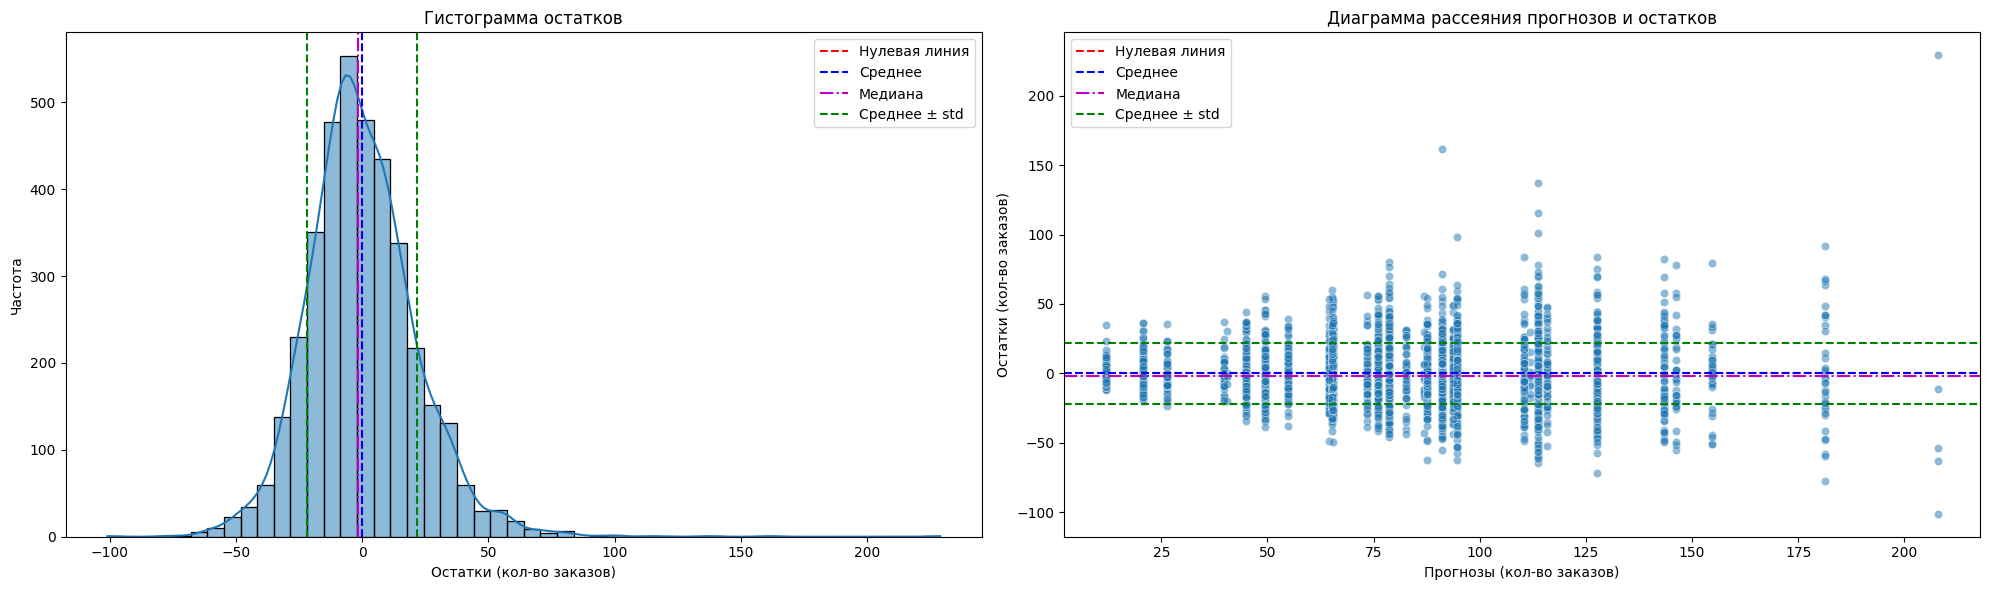

CPU times: total: 875 ms
Wall time: 1.02 s


In [47]:
%%time
analyze_residuals(
    y_train,
    random_search.predict(X_train),
    bins=50,
    figsize=(20, 6),
    title=None,
    lowess=False,
    lowess_frac=0.1,
    units='кол-во заказов'
)

Гистограмма остатков демонстрирует распределение, близкое к нормальному с центром в 0, что указывает на отсутствие систематической ошибки. Однако наличие выбросов в правом хвосте распределения (положительные остатки) свидетельствует о случаях, когда модель недооценивает фактические значения. Гомоскедастичность нарушена: дисперсия остатков больше при средних значений.

Важность признаков

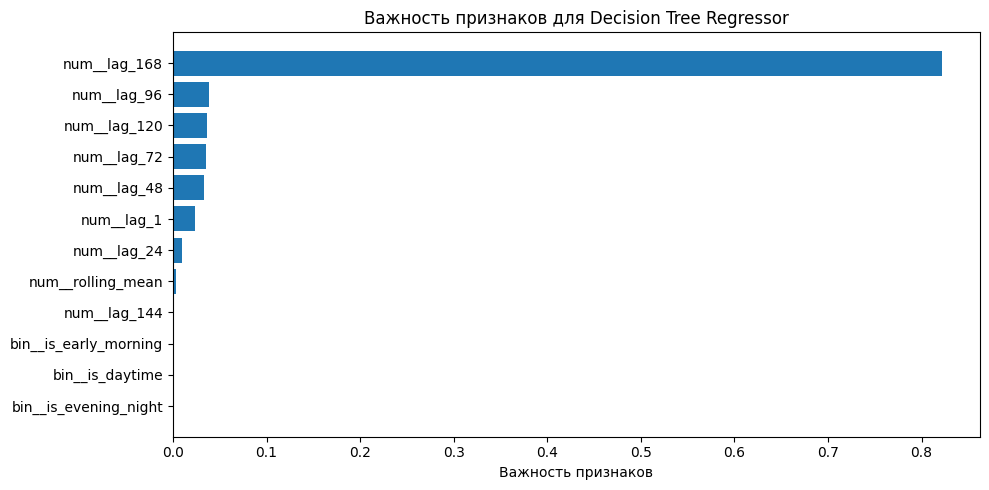

In [48]:
# 1. Извлекаем важности признаков
feature_importances = best_model_dtr.named_steps['regressor'].feature_importances_

# 2. Получаем названия признаков после предобработки
preprocessor = best_model_dtr.named_steps['preprocessor']

# Внутри Яндекс Практикума
#feature_names = get_feature_names_after_preprocessing(preprocessor)

# Вне Яндекс Практикума
feature_names = preprocessor.get_feature_names_out()

# 3. Создаем DataFrame
df_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 4. Сортируем по убыванию важности
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# 5. Построение графика
plt.figure(figsize=(10, 5))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Важность признаков')
plt.title('Важность признаков для Decision Tree Regressor')
plt.gca().invert_yaxis()  # Чтобы самый важный признак был сверху
plt.tight_layout()
plt.show()

Для модели `DecisionTreeRegressor` в топ-3 по важности относятся лаги и наиболее важный лаг `lag_168`. Наименьшую важность имеют признаки: `id_daytime`, `is_early_morning`, `is_evening_hight`.

### CatBoostRegressor

In [49]:
pipe_final_cb = Pipeline([
    ('regressor', CatBoostRegressor(
        random_state=RANDOM_STATE,
        verbose=False,  # чтобы не засорять вывод
        thread_count=1  # важно при n_jobs=-1 в RandomizedSearchCV
    ))
])

In [50]:
param_grid_cb = [
    {
        'regressor__depth': [4, 6, 8, 10],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__iterations': [300, 500],
        'regressor__l2_leaf_reg': [2, 4, 6],
        'regressor__random_strength': [0.5, 1, 2]
    }
]

In [51]:
random_search_cb = RandomizedSearchCV(
    pipe_final_cb,
    param_distributions=param_grid_cb,
    n_iter=10,  
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise'
)

In [52]:
%%time
random_search_cb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 9.56 s
Wall time: 5min 47s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('regressor',
                                              <catboost.core.CatBoostRegressor object at 0x0000024215E31430>)]),
                   n_jobs=-1,
                   param_distributions=[{'regressor__depth': [4, 6, 8, 10],
                                         'regressor__iterations': [300, 500],
                                         'regressor__l2_leaf_reg': [2, 4, 6],
                                         'regressor__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                         'regressor__random_strength': [0.5, 1,
                                                                        2]}],
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [53]:
best_model_cb = random_search_cb.best_estimator_
print('Лучшая модель CatBoost:\n', best_model_cb)

best_rmse_cb = -random_search_cb.best_score_

print(f'\033[1mRMSE на кросс-валидации: {best_rmse_cb:.4f}\033[0m')

Лучшая модель CatBoost:
 Pipeline(steps=[('regressor',
                 <catboost.core.CatBoostRegressor object at 0x0000024215E853A0>)])
RMSE на кросс-валидации: 23.6972


In [54]:
# лучшие гипрепараметры
best_params = random_search_cb.best_params_
print("Лучшие параметры CatBoost:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Лучшие параметры CatBoost:
  regressor__random_strength: 0.5
  regressor__learning_rate: 0.05
  regressor__l2_leaf_reg: 2
  regressor__iterations: 300
  regressor__depth: 8


Аналогично как и для предыдущих моделей метрика достигла цели, однако наблюдается переобучение.

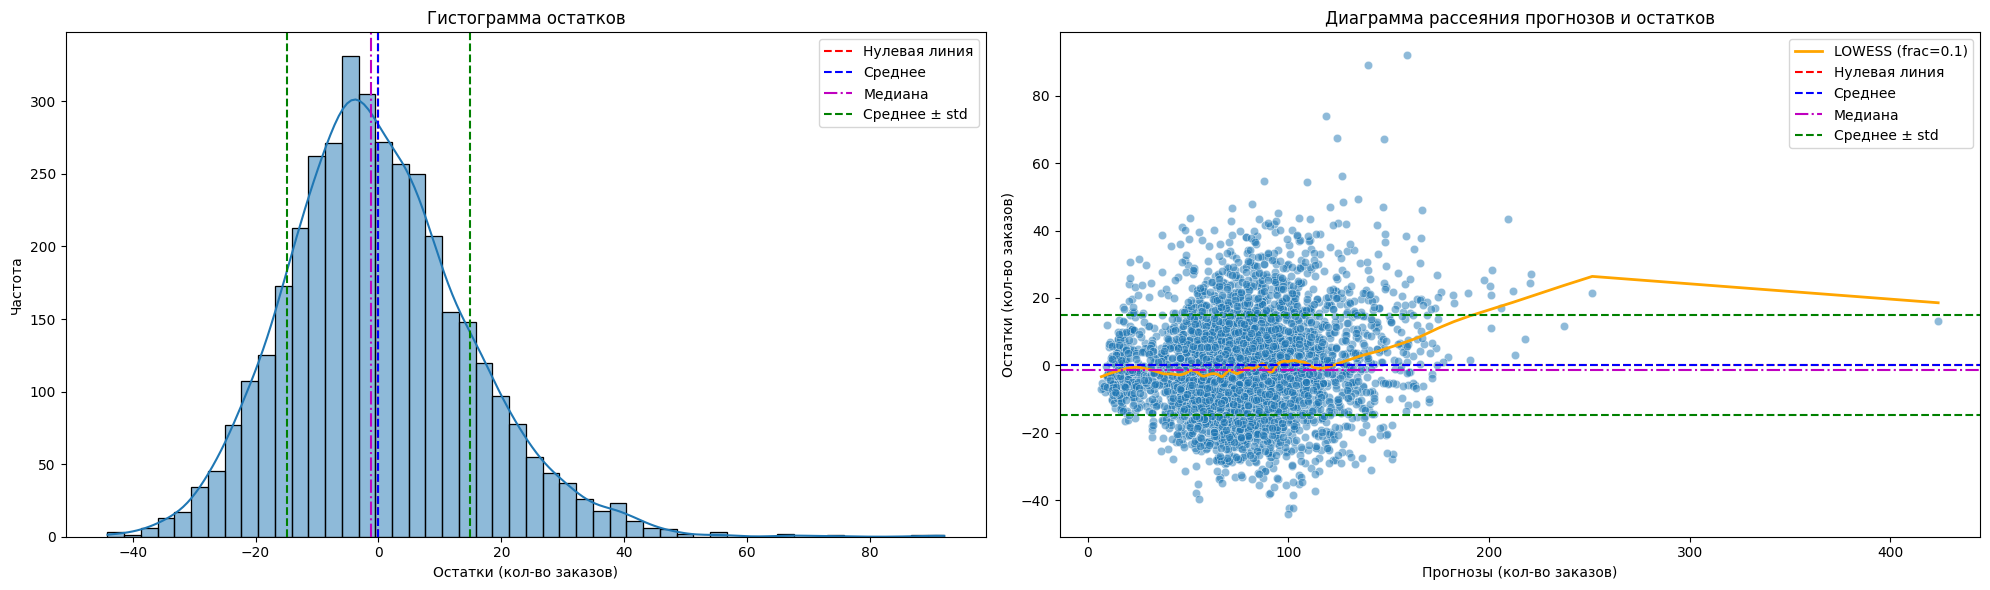

CPU times: total: 1.47 s
Wall time: 1.51 s


In [55]:
%%time
analyze_residuals(
    y_train,
    random_search_cb.predict(X_train),
    bins=50,
    figsize=(20, 6),
    lowess=True,
    lowess_frac=0.1,
    units='кол-во заказов'
)

Гистограмма остатков демонстрирует распределение, близкое к нормальному с центром в 0, что указывает на отсутствие систематической ошибки. Однако наличие выбросов в правом хвосте распределения (положительные остатки) свидетельствует о случаях, когда модель недооценивает фактические значения. Гомоскедастичность нарушена: дисперсия остатков увеличивается с ростом количества заказов.

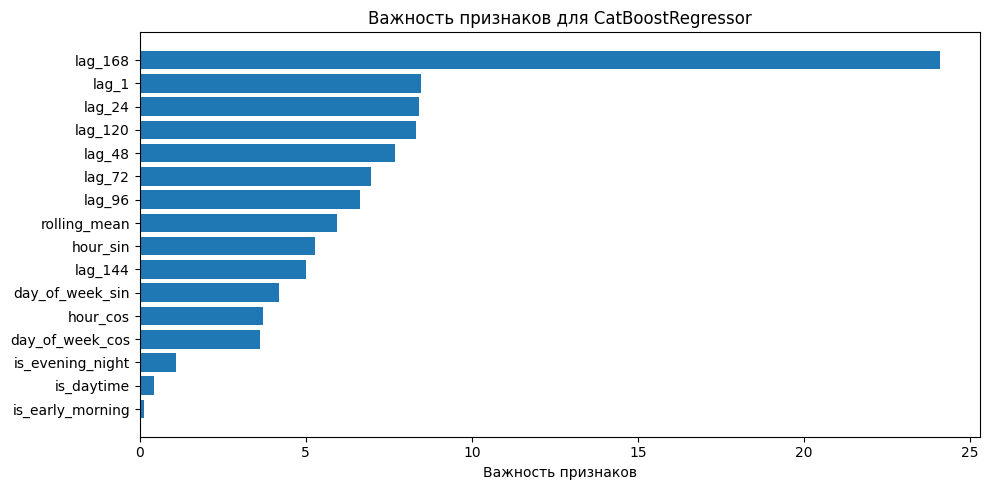

In [56]:
# Извлекаем важности
importances = best_model_cb.named_steps['regressor'].get_feature_importance()

# Имена признаков — просто колонки X_train
feature_names = X_train.columns

df_imp_cb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 5))
plt.barh(df_imp_cb['Feature'], df_imp_cb['Importance'])
plt.xlabel('Важность признаков')
plt.title('Важность признаков для CatBoostRegressor')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Для модели `CatBoostRegressor` в топ-3 по важности относятся лаги с наиболее важным лагом `lag_168`. Наименьшую важность имеют признаки: `id_daytime`, `is_early_morning`, `is_evening_night`. Данные результаты очень похожи на результаты модели `DecisionTreeRegressor`.

**Сравнение моделей**

In [57]:
# Собираем результаты в словарь для удобства
results = {
    'LinearRegression': best_rmse_lr,
    'DecisionTreeRegressor': best_rmse_dtr,
    'CatBoostRegressor': best_rmse_cb
}

# Находим модель с минимальным RMSE
best_model_name = min(results, key=lambda k: results[k])
best_rmse_value = results[best_model_name]

# Выводим результат
print("Результаты кросс-валидации (RMSE):")
for model, rmse in results.items():
    print(f"  {model}: {rmse:.4f}")

print(f"\nЛучшая модель: {best_model_name} с RMSE = {best_rmse_value:.4f}")

Результаты кросс-валидации (RMSE):
  LinearRegression: 23.0562
  DecisionTreeRegressor: 25.8402
  CatBoostRegressor: 23.6972

Лучшая модель: LinearRegression с RMSE = 23.0562


По метрикам лучше оказалась модель линейной регресси. Проведем ее тестирование

## Тестирование модели

In [58]:
# Извлекаем истинные значения
y_true_d = y_test

# Бейзлайны — просто соответствующие лаги
y_pred_naive = X_test['lag_1']        # предыдущий час
y_pred_yesterday = X_test['lag_24']   # тот же час вчера
y_pred_last_week = X_test['lag_168']  # тот же час и день недели неделю назад

# Считаем RMSE
rmse_naive = np.sqrt(mean_squared_error(y_true_d, y_pred_naive))
rmse_yesterday = np.sqrt(mean_squared_error(y_true_d, y_pred_yesterday))
rmse_last_week = np.sqrt(mean_squared_error(y_true_d, y_pred_last_week))

In [59]:
# Создаём датафрейм с результатами
baselines = pd.DataFrame({
    'Модель': [
        'Naive (lag_1)',
        'Yesterday (lag_24)',
        'Last week (lag_168)'
    ],
    'RMSE': [
        rmse_naive,
        rmse_yesterday,
        rmse_last_week
    ]
})

# Сортируем по RMSE (по возрастанию — лучшие сверху)
baselines = baselines.sort_values('RMSE').reset_index(drop=True)

# Выводим
print("Бейзлайны (RMSE):")
baselines

Бейзлайны (RMSE):


,Модель,RMSE
0,Last week (lag_168),38.580792
1,Yesterday (lag_24),57.470395
2,Naive (lag_1),57.601488


In [60]:
print('Метрики лучшей модели best_model_lr на тесте:')
results_lr = evaluate_model(grid_search, X_test, y_test, 'LinearRegressor')

Метрики лучшей модели best_model_lr на тесте:
=== LinearRegressor ===
MAE: 25.396
MSE: 1190.684
RMSE: 34.506
R²: 0.647
Среднее время обучения одной модели: 0.02 сек
----------------------------------------


Видно, что подготовленная модель МО дает лучшую метрику RMSE, чем бейзлайн `Last week (lag_168)`: 34.51 против 38.58.

## Итоговый вывод

Для построения модели прогнозирования количества заказов такси на следующий час с метрикой RMSE на тестовой выборке не больше 48 проведены детальные исследовательский и корреляционный анализы, использованы при моделировании три модели с подбором гиперпараметров.

На основе проведенного исследовательского анализа сформирован ряд важных признаков, характеризующих время суток, день недели, тип дня, а также представляющие собой лаги и скользящую среднюю.

Корреляционный анализ указал на суточную и недельные сезонности, что взято за основу при моделировании.

Лучшая из исследуемых моделей (`Linear Regression`) удовлетворила цели проекта (RMSE на тестовой выборке не больше 48). При этом она оказался эффективнее для решения поставленной задачи, чем бейзлайн `Last week (lag_168)`.

Для дальнейшего улучшения метрик в данном проекте можно поэкспериментировать с входными признаками: удалить по одной или все бинарные признаки, добавить лаги. При этом все исследуемые модели демонстрируют переобучение, что можно попытаться минимизировать с помощью более сильной регуляризации. Кроме этого возможно другие модели смогут справится с задачей более точно.